## import

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib  # 웹에서 데이터 다운시 사용

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
import os
img_dir = '/home/aiffel0049/aiffel/Exploration/14.human_segmentation/images/'
img_path = img_dir + 'image.jpg'
cat_path = img_dir + 'cat.jpg'
sea_path = img_dir + 'sea.jpeg'
img_orig = cv2.imread(img_path)
cat_orig = cv2.imread(cat_path)
sea_orig = cv2.imread(sea_path)
print(img_orig.shape, cat_orig.shape, sea_orig.shape)

(540, 960, 3) (800, 700, 3) (393, 700, 3)


## DeepLab Demo

### Model class

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE=513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()
            
        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)
        
    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input

    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict = {
                self.INPUT_TENSOR_NAME:[img_input]
            }
        )
        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### Model load

In [4]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/home/aiffel0049/aiffel/Exploration/14.human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print('temp directory', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                               download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory /home/aiffel0049/aiffel/Exploration/14.human_segmentation/models
model loaded successfully!


### inference

In [5]:
img_resized, img_seg = MODEL.run(img_orig)
cat_resized, cat_seg = MODEL.run(cat_orig)
sea_resized, sea_seg = MODEL.run(sea_orig)
print(img_orig.shape, img_resized.shape, img_seg.max())
print(cat_orig.shape, cat_resized.shape, cat_seg.max())
print(sea_orig.shape, sea_resized.shape, sea_seg.max())

(540, 960, 3) (288, 513, 3) 15
(800, 700, 3) (513, 448, 3) 8
(393, 700, 3) (288, 513, 3) 0


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### show segmentation area

In [7]:
def show_image_segmentation(resized, seg_map):
    category = seg_map.max()
    show = resized.copy()
    seg_map = np.where(seg_map == category, category, 0)  # 예측 중 사람만 추출
    mask = seg_map * (255 / seg_map.max())  # 255 normalization
    mask = mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    show = cv2.addWeighted(show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return mask

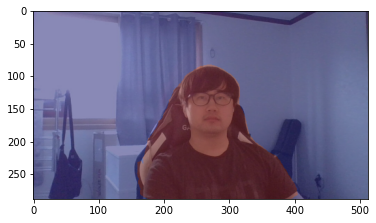

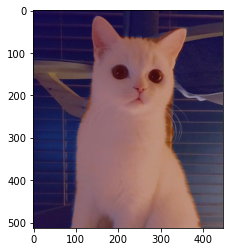

/home/aiffel0049/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  """
/home/aiffel0049/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


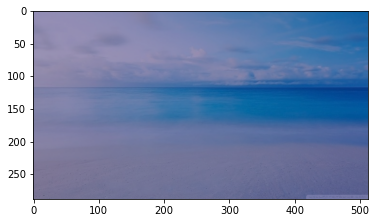

In [8]:
img_mask = show_image_segmentation(img_resized, img_seg)
cat_mask = show_image_segmentation(cat_resized, cat_seg)
sea_mask = show_image_segmentation(sea_resized, sea_seg)

In [9]:
def show_img_masked(img_orig, img_mask):
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1, 2, 1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1, 2, 2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()
    
    return img_mask_up

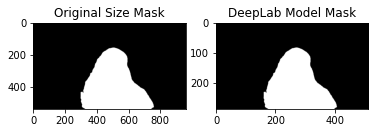

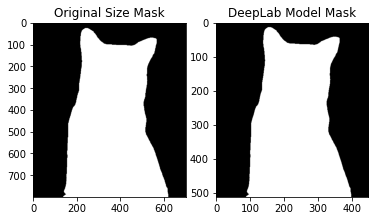

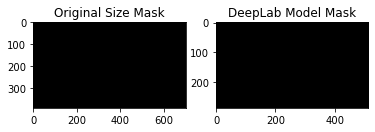

In [10]:
img_mask_up = show_img_masked(img_orig, img_mask)
cat_mask_up = show_img_masked(cat_orig, cat_mask)
sea_mask_up = show_img_masked(sea_orig, sea_mask)

## 배경 추출

In [11]:
def get_background(orig, mask_up):
    img_mask_color = cv2.cvtColor(mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(orig, img_bg_mask)
    plt.imshow(img_bg)
    plt.show()
    
    return img_mask_color, img_bg

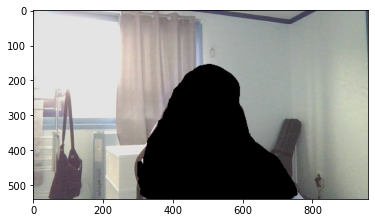

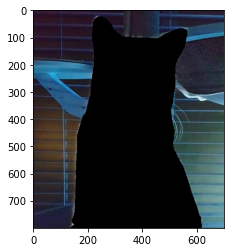

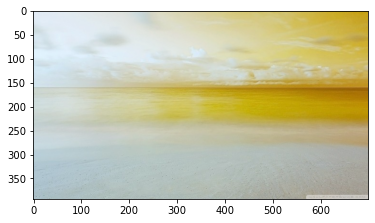

In [12]:
img_mask_color, img_bg = get_background(img_orig, img_mask_up)
cat_mask_color, cat_bg = get_background(cat_orig, cat_mask_up)
sea_mask_color, sea_bg = get_background(sea_orig, sea_mask_up)

## 배경 블러 및 합성

In [13]:
def bg_blur_and_concat(img_orig, img_mask_color, img_bg):
    img_bg_blur = cv2.blur(img_bg, (13, 13))
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

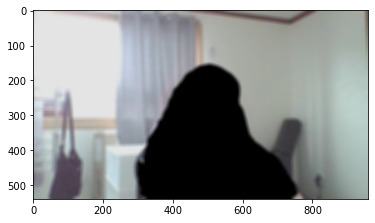

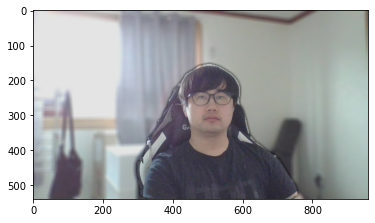

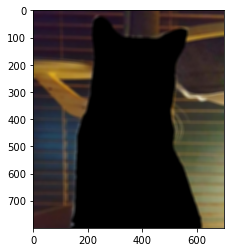

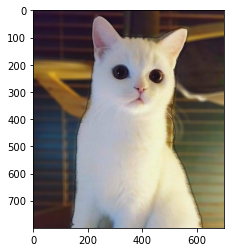

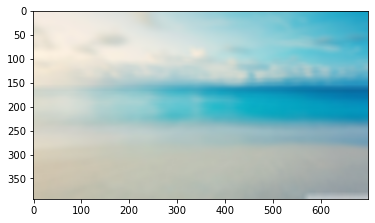

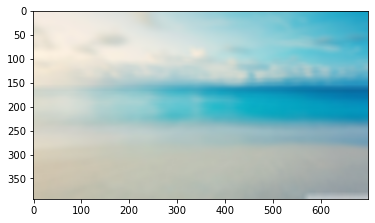

In [14]:
bg_blur_and_concat(img_orig, img_mask_color, img_bg)
bg_blur_and_concat(cat_orig, cat_mask_color, cat_bg)
bg_blur_and_concat(sea_orig, sea_mask_color, sea_bg)

### 문제점
- 제 사진과 고양이를 보면, 각각 잘못 검출된 부분이 존재
- 내 사진 : 의자부분까지 사람으로 검출
- 고양이 : 고양이 경계의 오른쪽에 붙어있는 배경일부가 고양이로 검출됨

## 객체만 확인

In [15]:
def get_obj(orig, mask_up):
    img_mask_color = cv2.cvtColor(mask_up, cv2.COLOR_GRAY2BGR)
    img_obj_mask = cv2.bitwise_and(img_mask_color)
    img_obj = cv2.bitwise_and(orig, img_obj_mask)
    plt.imshow(img_obj)
    plt.show()
    
    return img_mask_color, img_obj

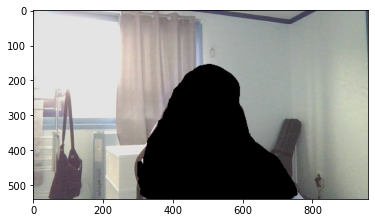

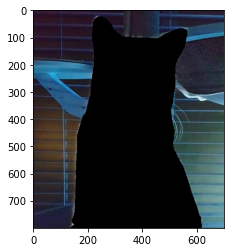

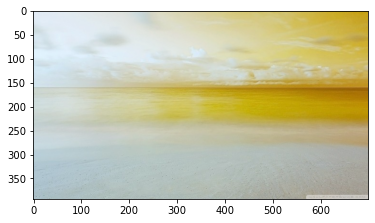

In [16]:
img_mask_color, img_obj = get_background(img_orig, img_mask_up)
cat_mask_color, cat_obj = get_background(cat_orig, cat_mask_up)
sea_mask_color, sea_obj = get_background(sea_orig, sea_mask_up)